# Pregunta 2: Filtrado de Imágenes Mediante Redes Neuronales

### Importar Bibliotecas

In [12]:
#Se importan las bibliotecas a utilizar
from brian2 import *
import numpy as np
import math as m
import scipy; from scipy import signal; from scipy import misc
import matplotlib.pyplot as plt
import warnings
import glob
%matplotlib inline


### Funciones Principales

In [10]:
def BuildInput(In, N):
    #Dicha función recibe como entrada una imagen y el tamaño en pixeles del camporeceptivo
    # y en base a esto calcula la imagen de entrada a las redes neuronales a simular
    
    warnings.filterwarnings('ignore');
    sc = 1.5
    ss = 3
    kc = (1/(2*m.pi*sc**2))
    ks = (1/(2*m.pi*ss**2))
    
    #Cálculo de Campos receptivos
    x, y = scipy.mgrid[-N/2:N/2 + 1, -N/2:N/2 + 1];
    Dn =  kc*np.exp(-(x**2 + y**2)/(2*sc**2))
    Dw =  ks*-np.exp(-(x**2 + y**2)/(2*ss**2))
    
    #Filtro 2D para Imagen de Entrada
    ImON  = scipy.signal.convolve2d(In,Dn+Dw,boundary='symm',mode='same')
    ImOFF = scipy.signal.convolve2d(In,-Dw-Dn,boundary='symm',mode='same')
    #Normalización
    ImON  = (ImON  - ImON.min())/ImON.max( )*256
    ImOFF = (ImOFF - ImOFF.min())/ImOFF.max()*256
    #Selección de pixel por medio para grilla de neuronas
    InputON  = ImON [::2,::2]
    InputOFF = ImOFF[::2,::2]
    
    #Ploteo de figuras
    fig = plt.figure(figsize=(12, 12))
    f1 = fig.add_subplot(131);f1.imshow(In, cmap='gray');f1.set_title('Original')
    f2 = fig.add_subplot(132);f2.imshow(Dn+Dw, cmap='gray');f2.set_title('Campo Receptivo 1')
    f3 = fig.add_subplot(133);f3.imshow(ImON,cmap='gray');f3.set_title('Imagen Filtrada')
    
    fig = plt.figure(figsize=(12, 12))
    f1 = fig.add_subplot(131);f1.imshow(In, cmap='gray');f1.set_title('Original')
    f2 = fig.add_subplot(132);f2.imshow(-Dw-Dn, cmap='gray');f2.set_title('Campo Receptivo 2')
    f3 = fig.add_subplot(133);f3.imshow(ImOFF,cmap='gray');f3.set_title('Imagen Filtrada')
    
    fig = plt.figure(figsize=(7, 7))
    f1 = fig.add_subplot(121);f1.imshow(InputON, cmap='gray');f1.set_title('Imagen Input a Red ON')
    f2 = fig.add_subplot(122);f2.imshow(InputOFF,cmap='gray');f2.set_title('Imagen Input a Red OFF')
    
    #Vector de salida
    return [InputON, InputOFF, Dn, Dw]


def RedNeuronal(Input,T,R):
    #Esta función simula la red neuronal una cantidad T de segundos, con el estímulo de entrada 
    #Input y el parámetro de configuración de la red R.
    
    tau = 1000*ms
    #Modelo LIF
    eqs = '''
    dv/dt = (R*I-v)/tau : volt
    I : volt
    '''
    #Corriente de excitación
    Ileak = Input.flatten()
    #Simulación de la red
    G = NeuronGroup(len(Ileak),eqs,threshold='v > 12*volt',reset='v = 0*mV',refractory=5*ms,method='linear')
    G.I = Ileak*volt
    #Resultado de simulación
    spikes = SpikeMonitor(G,variables= 'v')
    red=Network(G,spikes)
    #Ejecutar la simulación
    red.run(T*second)
    return(spikes)


def BuildLUT(D, path):
    #Esta función construye la Look Up Table a partir de las imágenes entregadas 
    LUT = zeros(50*50)
    cont = 0
    for filename in glob.glob(path+'*.jpg'):
        img     =  scipy.misc.imread(filename)
        imgConv =  (signal.convolve(img, D, mode="same"))[::2,::2]
        rank    =  sort(imgConv.flatten())[::-1]
        LUT     += rank
        cont    += 1
    LUT /= cont
    LUT = (LUT-LUT.min())/(LUT.max()-LUT.min())*256
    return LUT

def Sorting(spikes,N): 
    #Esta función ordena las neuronas por el número total de spikes generados de mayor
    # a menor
    cell_num = np.zeros(N)
    cell_len = np.zeros(N)
    for i in range(N):
        cell_len[i] = len(spikes['t'][i])
    cell_num = np.argsort(cell_len)[::-1]
    return(cell_num, cell_len)

def RandomOrder(spikes,N):
    #Esta función aleatoriza el orden de las neuronas
    cell_num = np.zeros(N)
    cell_len = np.zeros(N)
    for i in range(N):
        cell_len[i] = len(spikes['t'][i])
    cell_num = np.argsort(cell_len)[::-1]
    np.random.shuffle(cell_num)
    return(cell_num, cell_len)

def ReconstLUT(cell_num,LUT,D,N):
    #Esta función reconstruye la imagen a partir del LUT calculado con anterioridad
    x = (cell_num[:]/50)
    y = (np.floor(cell_num[:]%50))
    irec = np.zeros((100,100))
    for i in range(N):
        a = int(x[i])*2 - 1
        b = int(y[i])*2 - 1
        irec[a,b] = LUT[i]
    irec = scipy.signal.convolve2d(irec,D,mode='same')
    return(irec)

def ReconstCount(cell_num,cell_len,D,N):
    #Esta función reconstruye la imagen a partir del método de conteo
    x = (cell_num[:]/50)
    y = (np.floor(cell_num[:]%50))
    irec = np.zeros((100,100))
    for i in range(N):
        a = int(x[i])*2 - 1
        b = int(y[i])*2 - 1
        irec[a,b] = cell_len[i]
    irec = scipy.signal.convolve2d(irec,D,mode='same')
    return(irec)

### Input, Simulación de Redes y LUTs

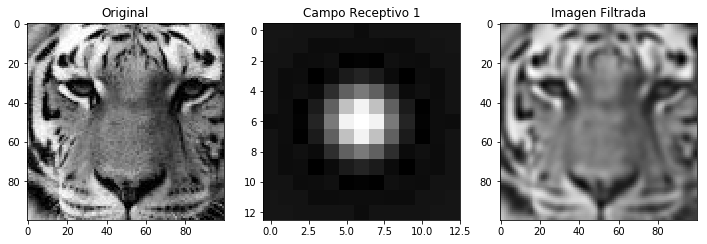

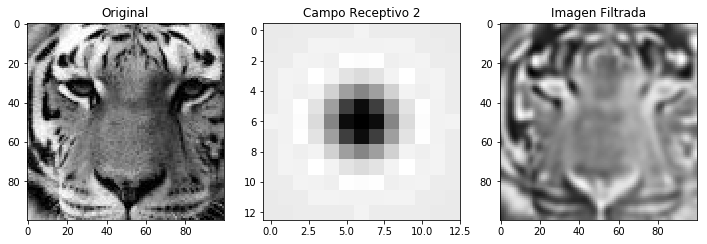

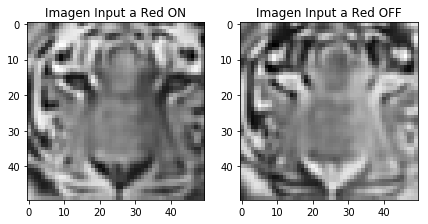

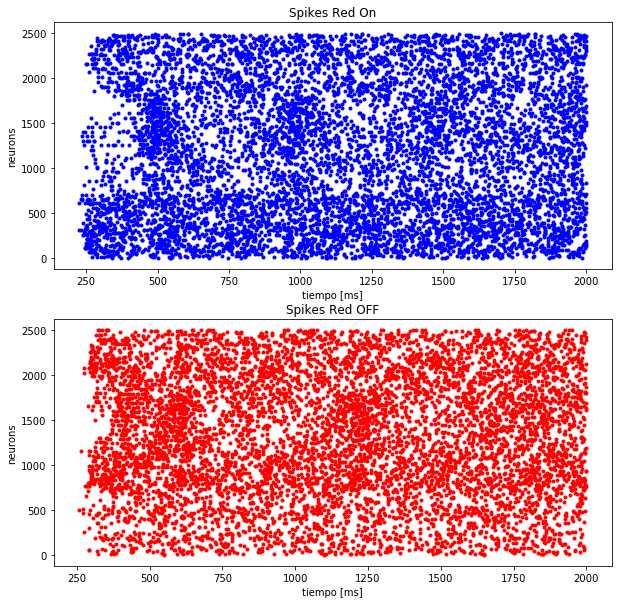

In [11]:
#Leer Imagen
path = './images/im05.jpg'
In   = scipy.misc.imread(path)

#Construir Input a la red
[InputON, InputOFF, Dn, Dw] = BuildInput(In, 12)

#Cuando se desee agregar ruido descomentar
#noiseON  = np.random.normal(InputON.mean(),10,[50,50])
#noiseOFF = np.random.normal(InputOFF.mean(),10,[50,50])
#InputON  = InputON + noiseON
#InputOFF = InputOFF + noiseOFF

#Simulación de redes ON y OFF
spikesON  = RedNeuronal(InputON,2,0.2)
spikesOFF = RedNeuronal(InputOFF,2,0.035)

#Rploteo de spikes generados por dichas redes
fig = plt.figure(figsize=(10, 10))
f1 = fig.add_subplot(211);f1.plot(spikesON.t/ms,spikesON.i,'.',color="blue");f1.set_title('Spikes Red On')
plt.xlabel('tiempo [ms]');plt.ylabel('neurons')
f2 = fig.add_subplot(212);f2.plot(spikesOFF.t/ms,spikesOFF.i,'.',color="red");f2.set_title('Spikes Red OFF')
plt.xlabel('tiempo [ms]');plt.ylabel('neurons')

#Construcción de Look Up Tables ON y OFF
folder = "./images/"
LUTON = zeros(50*50)
LUTON = BuildLUT(Dn-Dw,folder)
LUTOFF = zeros(50*50)
LUTOFF = BuildLUT(-Dw-Dn,folder)

### Reconstrucción con Selección Ordenada

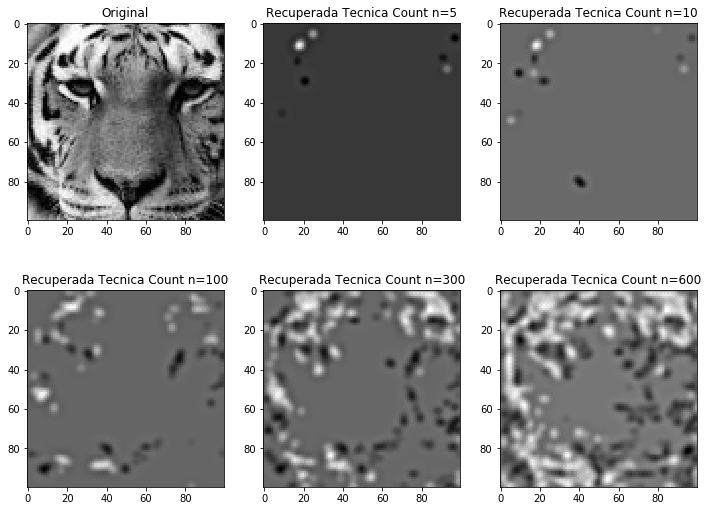

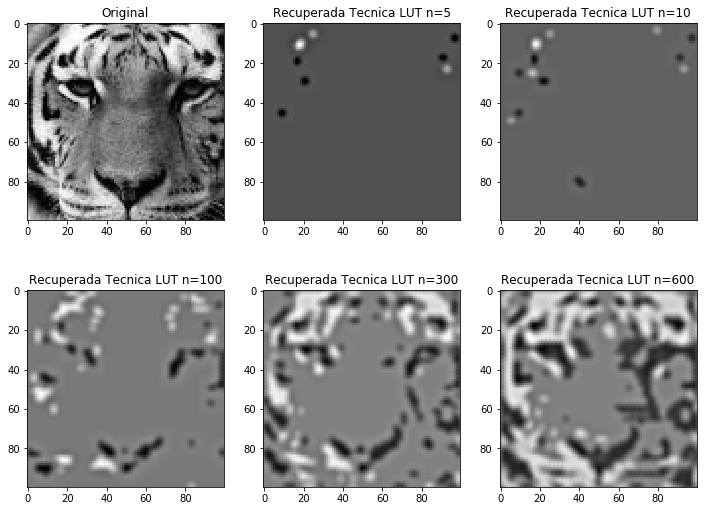

In [15]:
#Orden de cantidad de spikes generados junto a vector de cantidad asociado
[cell_num1, cell_len1] = Sorting(spikesON.all_values(),2500)
[cell_num2, cell_len2] = Sorting(spikesOFF.all_values(),2500)

#Reconstrucción con método de conteo para 5, 10, 100, 300 y 600 neuonas
irecCount_ON5    = ReconstCount(cell_num1,cell_len1,Dn+Dw,5)
irecCount_OFF5   = ReconstCount(cell_num2,cell_len2,-Dw-Dn,5)
irecCount_ON10   = ReconstCount(cell_num1,cell_len1,Dn+Dw,10)
irecCount_OFF10  = ReconstCount(cell_num2,cell_len2,-Dw-Dn,10)
irecCount_ON100  = ReconstCount(cell_num1,cell_len1,Dn+Dw,100)
irecCount_OFF100 = ReconstCount(cell_num2,cell_len2,-Dw-Dn,100)
irecCount_ON300  = ReconstCount(cell_num1,cell_len1,Dn+Dw,300)
irecCount_OFF300 = ReconstCount(cell_num2,cell_len2,-Dw-Dn,300)
irecCount_ON600  = ReconstCount(cell_num1,cell_len1,Dn+Dw,600)
irecCount_OFF600 = ReconstCount(cell_num2,cell_len2,-Dw-Dn,600)

#Reconstrucción con método LUT para 5, 10, 100, 300 y 600 neuonas
irecLUT_ON5    = ReconstLUT(cell_num1,LUTON,Dn+Dw,5)
irecLUT_OFF5   = ReconstLUT(cell_num2,LUTOFF,-Dw-Dn,5)
irecLUT_ON10   = ReconstLUT(cell_num1,LUTON,Dn+Dw,10)
irecLUT_OFF10  = ReconstLUT(cell_num2,LUTOFF,-Dw-Dn,10)
irecLUT_ON100  = ReconstLUT(cell_num1,LUTON,Dn+Dw,100)
irecLUT_OFF100 = ReconstLUT(cell_num2,LUTOFF,-Dw-Dn,100)
irecLUT_ON300  = ReconstLUT(cell_num1,LUTON,Dn+Dw,300)
irecLUT_OFF300 = ReconstLUT(cell_num2,LUTOFF,-Dw-Dn,300)
irecLUT_ON600  = ReconstLUT(cell_num1,LUTON,Dn+Dw,600)
irecLUT_OFF600 = ReconstLUT(cell_num2,LUTOFF,-Dw-Dn,600)

#Ploteo de resultados
fig = plt.figure(figsize=(12,9))
f1  = fig.add_subplot(231);f1.imshow(In, cmap='gray');f1.set_title('Original')
f2  = fig.add_subplot(232);f2.imshow(irecCount_ON5 + irecCount_OFF5, cmap='gray');f2.set_title('Recuperada Tecnica Count n=5')
f3  = fig.add_subplot(233);f3.imshow(irecCount_ON10 + irecCount_OFF10, cmap='gray');f3.set_title('Recuperada Tecnica Count n=10')
f4  = fig.add_subplot(234);f4.imshow(irecCount_ON100 + irecCount_OFF100, cmap='gray');f4.set_title('Recuperada Tecnica Count n=100')
f5  = fig.add_subplot(235);f5.imshow(irecCount_ON300 + irecCount_OFF300, cmap='gray');f5.set_title('Recuperada Tecnica Count n=300')
f6  = fig.add_subplot(236);f6.imshow(irecCount_ON600 + irecCount_OFF600, cmap='gray');f6.set_title('Recuperada Tecnica Count n=600')

fig = plt.figure(figsize=(12,9))
f1  = fig.add_subplot(231);f1.imshow(In, cmap='gray');f1.set_title('Original')
f2  = fig.add_subplot(232);f2.imshow(irecLUT_ON5 + irecLUT_OFF5, cmap='gray');f2.set_title('Recuperada Tecnica LUT n=5')
f3  = fig.add_subplot(233);f3.imshow(irecLUT_ON10 + irecLUT_OFF10, cmap='gray');f3.set_title('Recuperada Tecnica LUT n=10')
f4  = fig.add_subplot(234);f4.imshow(irecLUT_ON100 + irecLUT_OFF100, cmap='gray');f4.set_title('Recuperada Tecnica LUT n=100')
f5  = fig.add_subplot(235);f5.imshow(irecLUT_ON300 + irecLUT_OFF300, cmap='gray');f5.set_title('Recuperada Tecnica LUT n=300')
f6  = fig.add_subplot(236);f6.imshow(irecLUT_ON600 + irecLUT_OFF600, cmap='gray');f6.set_title('Recuperada Tecnica LUT n=600')


### Reconstrucción con Selección Aleatoria

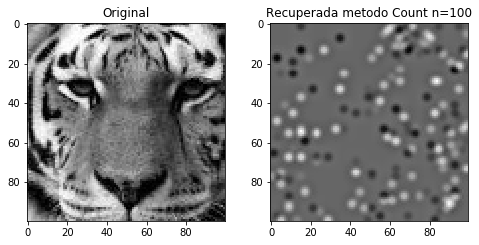

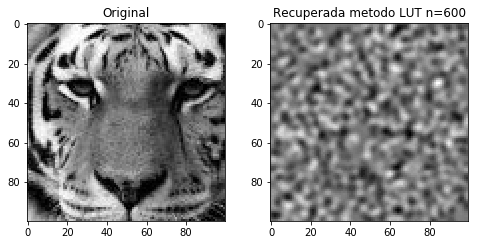

In [14]:
[cell_numONR, cell_lenON]   = RandomOrder(spikesON.all_values(),2500)
[cell_numOFFR, cell_lenOFF] = RandomOrder(spikesOFF.all_values(),2500)

irecCount_ONR600  = ReconstCount(cell_numONR,cell_lenON,Dn+Dw,100)
irecCount_OFFR600 = ReconstCount(cell_numOFFR,cell_lenOFF,-Dw-Dn,100)

irecLUT_ONR600  = ReconstLUT(cell_numONR,LUTON,Dn+Dw,600)
irecLUT_OFFR600 = ReconstLUT(cell_numOFFR,LUTOFF,-Dw-Dn,600)

fig = plt.figure(figsize=(8,8))
f1  = fig.add_subplot(221);f1.imshow(In, cmap='gray');f1.set_title('Original')
f2  = fig.add_subplot(222);f2.imshow(irecCount_ONR600 + irecCount_OFFR600, cmap='gray');f2.set_title('Recuperada metodo Count n=100')

fig = plt.figure(figsize=(8,8))
f1  = fig.add_subplot(221);f1.imshow(In, cmap='gray');f1.set_title('Original')
f2  = fig.add_subplot(222);f2.imshow(irecLUT_ONR600 + irecLUT_OFFR600, cmap='gray');f2.set_title('Recuperada metodo LUT n=600')
